# Odor Map for "Drawing the Borders of Olfactory Space"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import GridBox, Image, Text, Layout
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import plotly.graph_objects as go
import pyrfume
from pyrfume.plotting import plotly_embedding
from pyrfume.odorants import smiles_to_image
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
sns.set_style('white')

### Load Dragon descriptors for a representative sample of GDB-17
This file is too large for GitHub but is available on request

In [3]:
%time gdb = pd.read_csv('data/GDB_107k_dragon+SMILES.csv')

CPU times: user 1min 9s, sys: 4.89 s, total: 1min 14s
Wall time: 1min 14s


In [4]:
gdb_odor = gdb['Odor.probability']
gdb = gdb.set_index('SMILES').drop(['Unnamed: 0', 'No.', 'NAME', 'Odor.probability'], axis=1)
gdb.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50,bp,bp2
SMILES,,,,,,,,,,,,,,,,,,,,,
C,16.05,3.210,2.054,4.767,2.523,5.830,0.411,0.953,0.505,1.166,...,0,0,0,0,0,0,0,0,-177.307342,31437.893690
CC,30.08,3.760,3.580,7.651,4.284,9.246,0.448,0.956,0.536,1.156,...,0,0,0,0,0,0,0,0,-95.045438,9033.635377
C=C,28.06,4.677,3.054,5.767,3.523,6.830,0.509,0.961,0.587,1.138,...,0,0,0,0,0,0,0,0,-105.316103,11091.481570
C#C,26.04,6.510,2.527,3.884,2.761,4.415,0.632,0.971,0.690,1.104,...,0,0,0,0,0,0,0,0,-116.063741,13470.791874
C1CC1,42.09,4.677,4.580,8.651,5.284,10.246,0.509,0.961,0.587,1.138,...,0,0,0,0,0,0,0,0,-42.237821,1784.033532


#### Get Dragon descriptors for molecules on the the Pyrfume master list
This file is too large for GitHub but is available on request

In [5]:
pf = pd.read_csv('data/AllDragon_November2020.csv')
pf['SMILES'] = pf['NAME'].apply(lambda x: x.split(': ')[1])
pf = pf.set_index('SMILES').drop(['Unnamed: 0', 'No.', 'NAME'], axis=1)
pf.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50,bp,bp2
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(CN)O,75.13,5.366,6.843,13.964,7.506,16.369,0.489,0.997,0.536,1.169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.854271,3232.408177
C(CCl)Cl,98.96,12.370,5.235,8.298,6.000,9.134,0.654,1.037,0.750,1.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.208621,11068.853964
CCC(C)C(=O)C(=O)O,130.16,6.851,10.778,19.400,11.170,21.704,0.567,1.021,0.588,1.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.833212,23357.990843
CC(C)C(=O)C(=O)O,116.13,7.258,9.252,16.516,9.409,18.289,0.578,1.032,0.588,1.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.122340,17721.557461
C(CC(=O)O)C(=O)C(=O)O,146.11,9.132,10.154,17.287,9.557,18.293,0.635,1.080,0.597,1.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.590691,29787.546578


#### Use the provenance of the master list to identify which molecules did not come from a PI's chemical cabinet, i.e. those that came from the olfaction literature or databases, which we want to show here as "known odorants".

In [6]:
pyrfume_master = pd.read_csv('data/all-pyrfume-cids-properties.csv').set_index('SMILES')
pyrfume_non_cabinet = pyrfume_master.drop([c for c in pyrfume_master if 'cabinet' in c] + ['Name', 'MW', 'IUPACName'], axis=1).sum(axis=1)
pyrfume_nc = pyrfume_non_cabinet[pyrfume_non_cabinet>0]

#### Create deisomerized versions of the SMILES strings to avoid issues where one version of the molecule might have isomeric annotations and another may not.

In [7]:
def deisomerize(df):
    df.index = df.index.map(lambda x: x.replace('@','').replace('/', '').replace('\\',''))
    df = df[~df.index.duplicated()]
    return df

gdb = deisomerize(gdb)
pf = deisomerize(pf)
pyrfume_nc = deisomerize(pyrfume_nc)

#### Merge these sources

In [8]:
pf = pf.loc[pf.index.intersection(pyrfume_nc.index)]
pf.shape

(8748, 4887)

#### Remove molecules containing certain atoms

In [9]:
banned = ['Li', 'Be', 'B', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']
banned += ['Ga', 'Ge', 'As', 'Se', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Cs', 'Ba', 'Ir', 'Pt', 'Au', 'Hg', 'Pb', 'Bi', '+', '-']
permitted = pf.index.map(lambda x: not any([element in x for element in banned]))
pf = pf[permitted]
pf.shape

(8267, 4887)

In [10]:
# Check that features are the same
assert list(gdb.columns) == list(pf.columns)

#### Remove problematic features (too many NaNs)

In [11]:
# Remove 
max_nans = 1000  # Maximum NaNs allowed for each feature
is_good_feature = gdb.isnull().sum(axis=0)<=max_nans
good_features = is_good_feature[is_good_feature].index

In [12]:
len(good_features)

4864

In [13]:
gdb_good = gdb[good_features]  # Filter out features with more than this number of NaNs
pf_good = pf[good_features]
#pyr_good = pyr[good_features]
all_good = pd.concat([gdb_good, pf_good])
#all_good = pd.concat([gdb_good, pyr_good])
n_gdb = gdb.shape[0]

In [14]:
# Fraction of remaining values that are NaN
all_good.isnull().mean().mean()

0.0005796601975081523

#### Impute and Scale

In [15]:
#imputer = IterativeImputer()
imputer = SimpleImputer(strategy='median')
%time all_imputed = imputer.fit_transform(all_good)

CPU times: user 1min 8s, sys: 7.6 s, total: 1min 15s
Wall time: 1min 15s


In [16]:
mms = MinMaxScaler()
all_norm = mms.fit_transform(all_imputed)

#### Mask a random 75% of the odor probabilities and compute the embedding

In [17]:
gdb_odor_masked = gdb_odor.copy().astype(int)
gdb_odor_masked[np.random.choice(n_gdb, size=int(0.75*n_gdb), replace=False)] = -1

In [18]:
gdb_norm = all_norm[:n_gdb]
u = umap.UMAP(min_dist=1)
%time gdb_umap = u.fit_transform(gdb_norm, y=gdb_odor_masked)

CPU times: user 47min 58s, sys: 2min 5s, total: 50min 3s
Wall time: 3min 32s


In [19]:
#odor_umap = gdb_umap[gdb_odor]
pf_norm = all_norm[n_gdb:]
pf_umap = u.transform(pf_norm)

In [20]:
gdb_umap = pd.DataFrame(gdb_umap, index=gdb.index)
pf_umap = pd.DataFrame(pf_umap, index=pf.index)
gdb_umap['p'] = gdb_odor.values

#### Make the static version of the figure

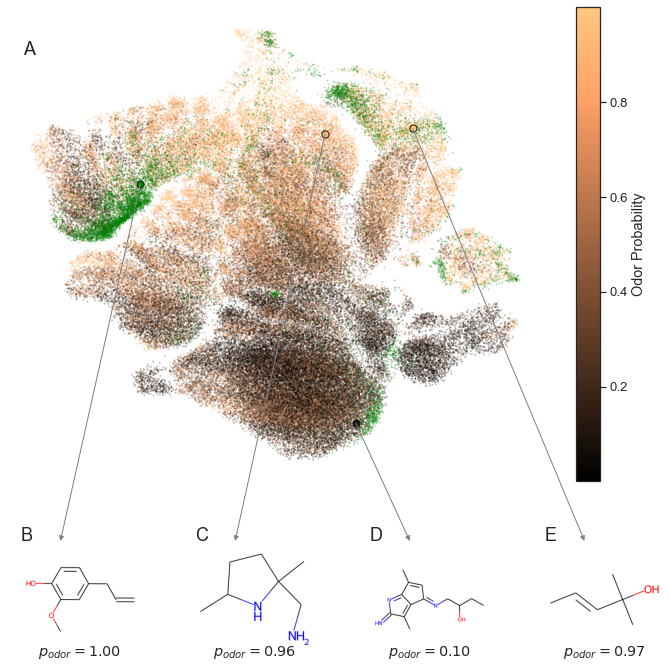

In [21]:
from matplotlib.patches import ConnectionPatch
sns.set(font_scale=1.2)
sns.set_style('white')
fig = plt.figure(figsize=(12, 12), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=4, height_ratios=[4, 1])

ax_umap = fig.add_subplot(gs[0, :])
im = ax_umap.scatter(*gdb_umap[[0, 1]].T.values, c=gdb_odor.values, cmap='copper', alpha=0.2, s=1)
ax_umap.scatter(*pf_umap[[0, 1]].T.values, c='green', cmap='copper', alpha=0.2, s=1)
ax_umap.axes.axis('off')
cbar = fig.colorbar(im)
cbar.set_label('Odor Probability')
cbar.set_alpha(1)
cbar.draw_all()
ax_umap.text(0.03, 0.9, 'A', fontsize=18, transform=ax_umap.transAxes)

def umap_mol_panel(letter, row, col, smiles):
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(smiles_to_image(smiles, png=False))
    try:
        x, y = gdb_umap.loc[smiles, [0, 1]]
        umap = gdb_umap
        p = umap.loc[smiles, 'p']
        cmap = get_cmap('copper')
        color = cmap(p) 
    except KeyError:
        x, y = pf_umap.loc[smiles, [0, 1]]
        umap = pf_umap
        p = 1
        color = 'green'
    ax_umap.scatter([x], [y], s=50, marker='o', color=color, edgecolor='k')
    ax.text(0.5, 0.03, r'$p_{odor}=%.2f$' % p, ha='center', transform=ax.transAxes)
    ax.axes.axis('off')
    ax.text(0, 1, letter, fontsize=18, transform=ax.transAxes)
    con = ConnectionPatch(xyA=(x, y), xyB=(100, 0), axesA=ax_umap, axesB=ax,
                          coordsA='data', coordsB='data', color="grey", arrowstyle="-|>")
    ax.add_artist(con)
    
umap_mol_panel('B', 1, 0, 'COC1=C(C=CC(=C1)CC=C)O')
umap_mol_panel('C', 1, 1, 'C[C]1(CN)CC[CH](N1)C')
umap_mol_panel('D', 1, 2, 'CC[CH](CN=c1cc(c2c1c(C)c(=N)n2)C)O')
umap_mol_panel('E', 1, 3, 'CC=CC(O)(C)C')

#plt.tight_layout()

#### Save embedding for use in the dynamic one (see dynamic.ipynb)

In [22]:
import pickle
with open('data/gdb_umap.pkl', 'wb') as f:
    pickle.dump(gdb_umap, f)
with open('data/pf_umap.pkl', 'wb') as f:
    pickle.dump(pf_umap, f)